# eQTL boxplot

This is script ported from python to fix unknown plotting error.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggpubr)
})

## Functions

In [2]:
feature = "genes"

### Basic loading functions

In [3]:
get_residualized_df <- function(){
    expr_file = paste0("/ceph/projects/v4_phase3_paper/analysis/eqtl_analysis/all/",
                      feature,"/expression_gct/covariates/residualized_expression/_m/",
                      feature, "_residualized_expression.csv")
    return(data.table::fread(expr_file) %>% column_to_rownames("gene_id"))
}
memRES <- memoise::memoise(get_residualized_df)

get_biomart_df <- function(){
    biomart = data.table::fread("../_h/biomart.csv")
}
memMART <- memoise::memoise(get_biomart_df)

get_pheno_df <- function(){
    phenotype_file = paste0('/ceph/projects/v4_phase3_paper/inputs/',
                            'phenotypes/_m/merged_phenotypes.csv')
    return(data.table::fread(phenotype_file))
}
memPHENO <- memoise::memoise(get_pheno_df)

get_genotypes <- function(){
    traw_file = paste0("/ceph/projects/brainseq/genotype/download/topmed/convert2plink/",
                      "filter_maf_01/a_transpose/_m/LIBD_Brain_TopMed.traw")
    traw = data.table::fread(traw_file) %>% rename_with(~ gsub('\\_.*', '', .x))
    return(traw)
}
memSNPs <- memoise::memoise(get_genotypes)

### eQTL and helpful functions

In [4]:
feature_map <- function(feature){
    return(list("genes"="Gene", "transcripts"= "Transcript", 
                "exons"= "Exon", "junctions"= "Junction")[[feature]])
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

get_caudate_eqtls <- function(){
    mashr_file = paste0("../../../meta_analysis/summary_table/_m/",
                       "BrainSeq_caudate_eQTL.txt.gz")
    return(data.table::fread(mashr_file) %>% 
           filter(Type == feature_map(feature)) %>% 
           select(gene_id, variant_id, AA, EA))
}
memCAUDATE <- memoise::memoise(get_caudate_eqtls)

### Basic eQTL plotting functions

In [5]:
get_geno_annot <- function(){
    return(memSNPs() %>% select(CHR, SNP, POS, COUNTED, ALT))
}

get_snps_df <- function(){
    return(memSNPs() %>% select("SNP", starts_with("Br")))
}

letter_snp <- function(number, a0, a1){
    if(is.na(number)){ return(NA) }
    if( length(a0) == 1 & length(a1) == 1){
        seps = ""; collapse=""
    } else {
        seps = " "; collapse=NULL
    }
    return(paste(paste0(rep(a0, number), collapse = collapse), 
                 paste0(rep(a1, (2-number)), collapse = collapse), sep=seps))
}

get_snp_df <- function(variant_id, gene_id){
    zz = get_geno_annot() %>% filter(SNP == variant_id)
    xx = get_snps_df() %>% filter(SNP == variant_id) %>% 
        column_to_rownames("SNP") %>% t %>% as.data.frame %>% 
        rownames_to_column("BrNum") %>% mutate(COUNTED=zz$COUNTED, ALT=zz$ALT) %>% 
        rename("SNP"=all_of(variant_id))
    yy = memRES()[gene_id, ] %>% t %>% as.data.frame %>% 
        rownames_to_column("BrNum") %>% inner_join(memPHENO(), by="BrNum")
    ## Annotated SNPs
    letters = c()
    for(ii in seq_along(xx$COUNTED)){
        a0 = xx$COUNTED[ii]; a1 = xx$ALT[ii]; number = xx$SNP[ii]
        letters <- append(letters, letter_snp(number, a0, a1))
    }
    xx = xx %>% mutate(LETTER=letters, ID=paste(SNP, LETTER, sep="\n"))
    df = inner_join(xx, yy, by="BrNum") %>% mutate_if(is.character, as.factor)
    return(df)
}
memDF <- memoise::memoise(get_snp_df)

get_gene_symbol <- function(gene_id){
    ensemblID = gsub("\\..*", "", gene_id)
    geneid = memMART() %>% filter(ensembl_gene_id == gsub("\\..*", "", gene_id))
    if(dim(geneid)[1] == 0){
        return("")
    } else {
        return(geneid$external_gene_name)
    }
}

In [6]:
plot_simple_eqtl <- function(fn, gene_id, variant_id, eqtl_annot, y0=NULL, y1=NULL){
    if(is.null(y0)){ y0 = quantile(memDF(variant_id, gene_id)[[gene_id]], probs=c(0.01))[[1]] - 0.2 }
    if(is.null(y1)){ y1 = quantile(memDF(variant_id, gene_id)[[gene_id]], probs=c(0.99))[[1]] + 0.2 }
    bxp = memDF(variant_id, gene_id) %>%
        ggboxplot(x="ID", y=gene_id, fill="Race", color="Race", add="jitter", 
                  xlab=variant_id, ylab="Residualized Expression", outlier.shape=NA,
                  add.params=list(alpha=0.5), alpha=0.4, legend="bottom", 
                  palette="npg", ylim=c(y0,y1), ggtheme=theme_pubr(base_size=20, border=TRUE)) +
        font("xy.title", face="bold") + 
        ggtitle(paste(get_gene_symbol(gene_id), gene_id, eqtl_annot, sep='\n')) +
        theme(plot.title = element_text(hjust = 0.5, face="bold"))
    print(bxp)
    save_ggplots(fn, bxp, 7, 7)
}

### GWAS plotting functions

In [7]:
get_gwas_snps <- function(){
    gwas_snp_file = paste0('/ceph/projects/v4_phase3_paper/inputs/sz_gwas/pgc3/',
                          'map_phase3/_m/libd_hg38_pgc2sz_snps_p5e_minus8.tsv')
    gwas_df = data.table::fread(gwas_snp_file) %>% arrange(P)
    return(gwas_df)
}
memGWAS <- memoise::memoise(get_gwas_snps)

get_gwas_snp <- function(variant){
    return(memGWAS() %>% filter(our_snp_id == variant))
}

get_risk_allele <- function(variant){
    gwas_snp = get_gwas_snp(variant)
    if(gwas_snp$OR > 1){
        ra = gwas_snp$A1
    }else{
        ra = gwas_snp$A2
    }
    return(ra)
}

get_eqtl_gwas_df <- function(){
    return(memCAUDATE() %>% inner_join(memGWAS(), by=c("variant_id"="our_snp_id")))
}

get_gwas_ordered_snp_df <- function(variant_id, gene_id, pgc3_a1_same_as_our_counted, OR){
    df = memDF(variant_id, gene_id)
    if(!pgc3_a1_same_as_our_counted){ # Fix bug with matching alleles!
        if(OR < 1){ df = df %>% mutate(SNP = 2-SNP, ID=paste(SNP, LETTER, sep="\n")) }
    } else {
        if(OR > 1){ df = df %>% mutate(SNP = 2-SNP, ID=paste(SNP, LETTER, sep="\n")) }
    }
    return(df)
}

plot_gwas_eqtl <- function(fn, gene_id, variant_id, eqtl_annot, pgc3_a1_same_as_our_counted, 
                           OR, title){
    dt = get_gwas_ordered_snp_df(variant_id, gene_id, pgc3_a1_same_as_our_counted, OR)
    bxp = dt %>% mutate_if(is.character, as.factor) %>%
        ggboxplot(x="ID", y=gene_id, fill="Race", color="Race", add="jitter", 
                  xlab=variant_id, ylab="Residualized Expression", outlier.shape=NA,
                  add.params=list(alpha=0.5), alpha=0.4, legend="bottom", #ylim=c(y0,y1),
                  palette="npg", ggtheme=theme_pubr(base_size=20, border=TRUE)) +
        font("xy.title", face="bold") + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5, face="bold"))
    print(bxp)
    save_ggplots(fn, bxp, 7, 8)
}

## Plot eQTL

In [8]:
eGenes <- memCAUDATE() %>% arrange(AA, EA) %>% group_by(gene_id) %>% slice(1) %>% arrange(AA, EA)
eGenes %>% head(5)

gene_id,variant_id,AA,EA
<chr>,<chr>,<dbl>,<dbl>
ENSG00000006282.20,chr17:50538753:C:G,-2.220446e-16,-2.220446e-16
ENSG00000011376.9,chr3:45538041:T:A,-2.220446e-16,-2.220446e-16
ENSG00000013573.16,chr12:31070388:A:G,-2.220446e-16,-2.220446e-16
ENSG00000037280.15,chr5:180609318:A:G,-2.220446e-16,-2.220446e-16
ENSG00000037474.14,chr5:6619620:C:T,-2.220446e-16,-2.220446e-16


### DRD2 plot

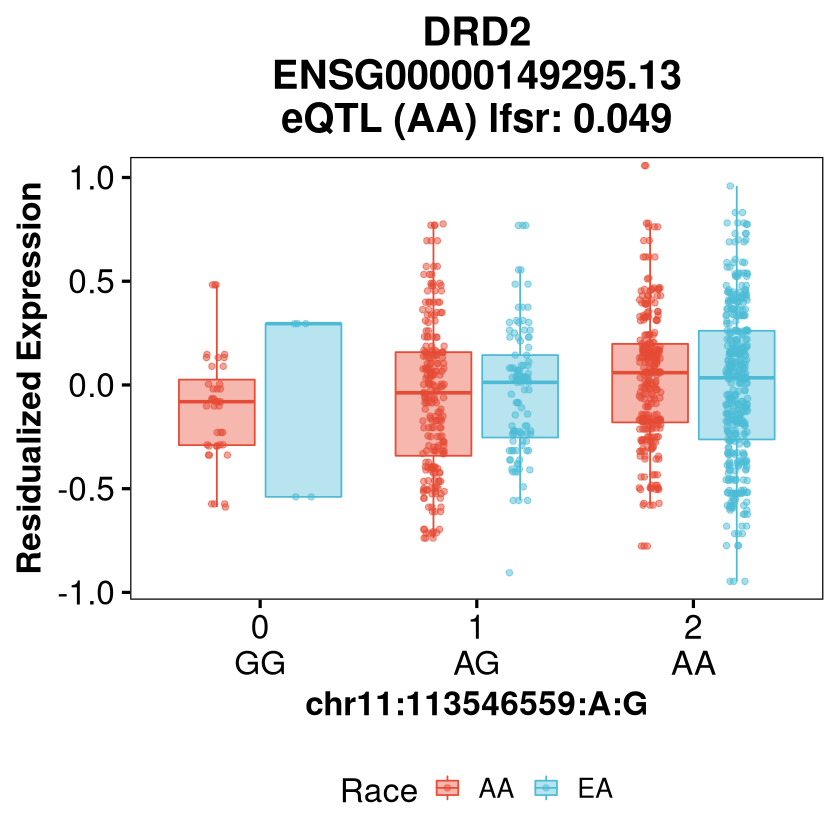

In [9]:
drd2_id = "ENSG00000149295.13"
drd2_df = memCAUDATE() %>% filter(gene_id == drd2_id)
eqtl_annot = paste("eQTL (AA) lfsr:", signif(drd2_df$AA, 2))
fn = "drd2_eqtl"
plot_simple_eqtl(fn, drd2_df$gene_id, drd2_df$variant_id, eqtl_annot)

### Top 5 eQTLs

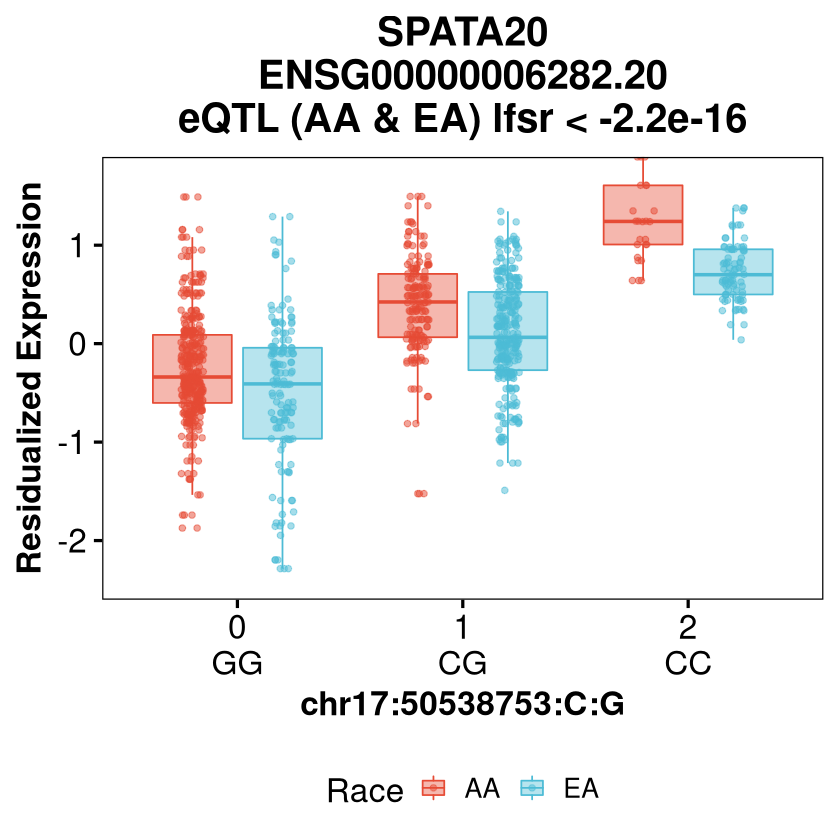

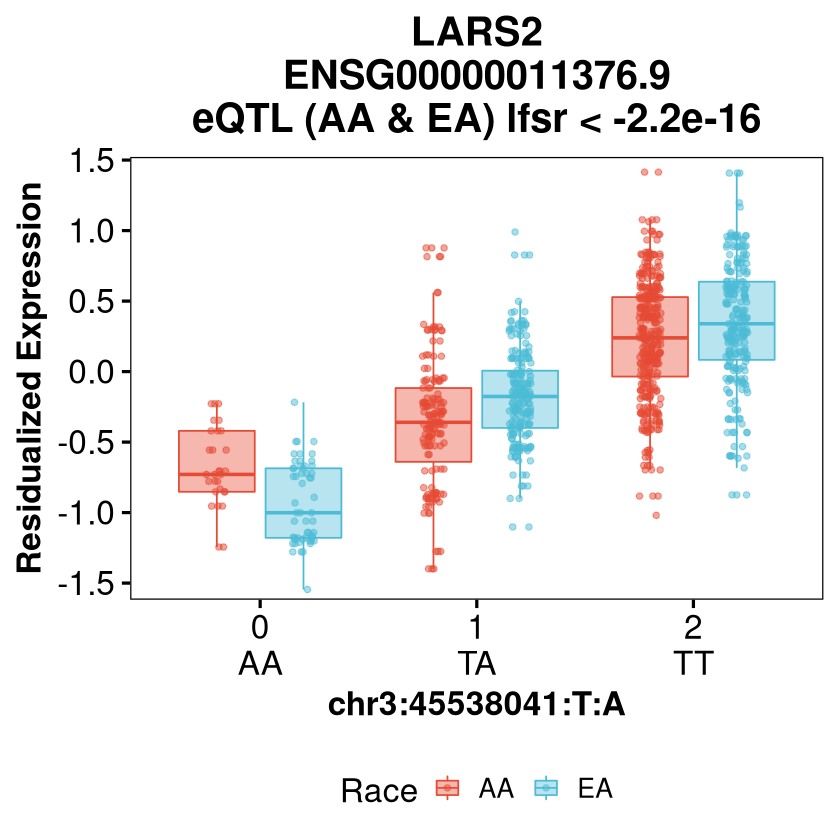

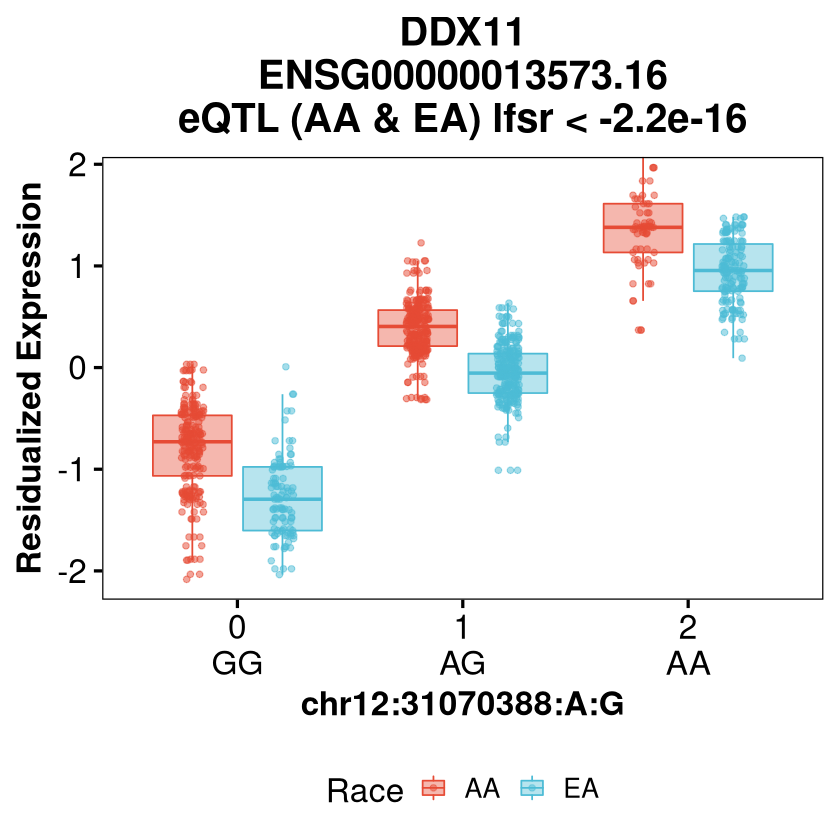

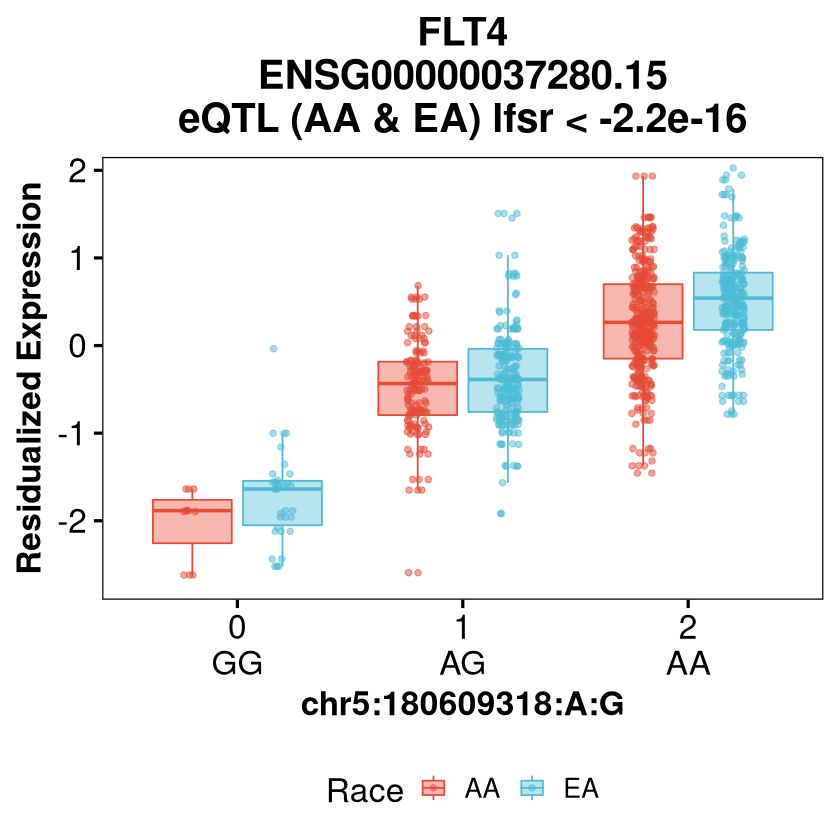

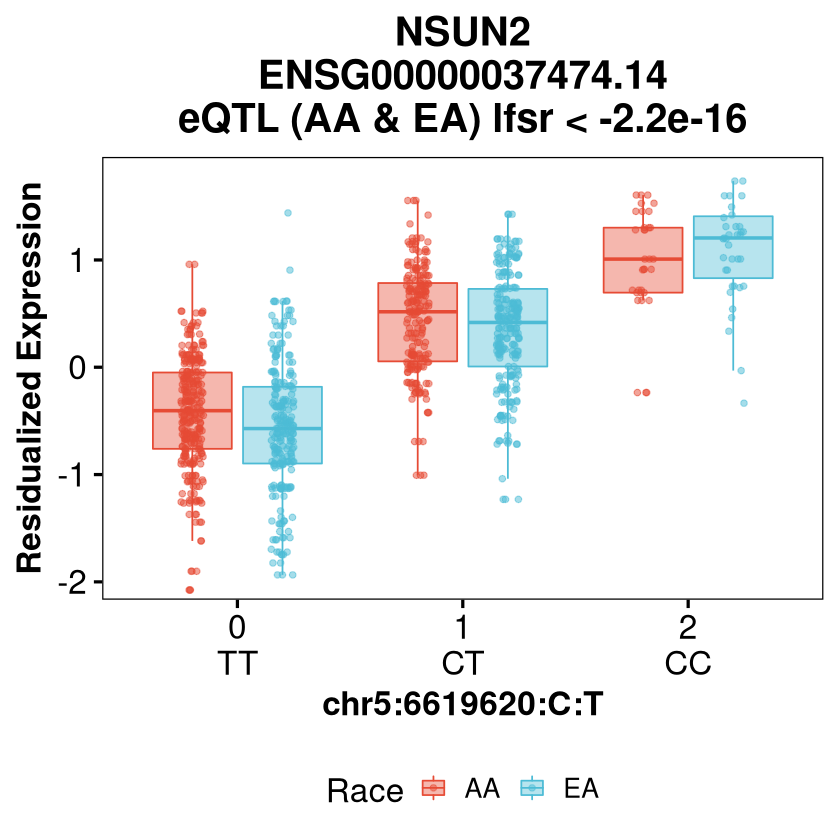

In [10]:
for(num in 1:5){
    variant_id = eGenes$variant_id[num]
    gene_id = eGenes$gene_id[num]
    eqtl_annot = paste("eQTL (AA & EA) lfsr <", signif(eGenes$AA[num], 2))
    fn = paste0("top_",num,"_eqtl")
    plot_simple_eqtl(fn, gene_id, variant_id, eqtl_annot)
}

### Top 5 GWAS associated eQTLs

In [10]:
eGenes_gwas = get_eqtl_gwas_df() %>% arrange(AA, EA, P) %>% group_by(gene_id) %>% slice(1) %>% arrange(AA, EA, P)
eGenes_gwas %>% head(5)

gene_id,variant_id,AA,EA,V1,chrN,cm,pos,our_counted,our_alt,⋯,INFO,OR,SE,P,ngt,hg19chrc,hg38chrc,hg38pos,pgc3_a1_same_as_our_counted,rsid
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<chr>
ENSG00000204428.12,chr6:31652243:A:G,-2.220446e-16,-2.220446e-16,17645,6,0,31652243,G,A,⋯,0.995,1.05908,0.0082,2.014e-12,26,chr6,chr6,31652243,FALSE,rs813115
ENSG00000204540.10,chr6:31115210:A:G,-2.220446e-16,-2.220446e-16,17194,6,0,31115210,G,A,⋯,1.010,1.05643,0.0097,1.371e-08,58,chr6,chr6,31115210,FALSE,rs3094220
ENSG00000179344.16,chr6:32658534:T:C,-2.220446e-16,-2.220446e-16,18377,6,0,32658534,C,T,⋯,0.770,1.05096,0.0090,3.860e-08,48,chr6,chr6,32658534,FALSE,rs6906021
ENSG00000214425.7,chr17:45995618:A:G,-2.220446e-16,-2.220446e-16,5223,17,0,45995618,G,A,⋯,0.961,1.06099,0.0108,4.581e-08,0,chr17,chr17,45995618,FALSE,rs112572874
ENSG00000198502.5,chr6:32466954:T:A,-2.220446e-16,4.029332e-12,18305,6,0,32466954,A,T,⋯,0.951,1.05834,0.0094,1.723e-09,0,chr6,chr6,32466954,FALSE,rs9268972


In [ ]:
for(num in 1:5){
    fn = paste("top",num,"eqtl_pgc3_variants", sep="_")
    variant_id = eGenes_gwas$variant_id[num]
    gene_id = eGenes_gwas$gene_id[num]
    pgc3_a1_same_as_our_counted = eGenes_gwas$pgc3_a1_same_as_our_counted[num]
    OR = eGenes_gwas$OR[num]
    eqtl_annot = paste("eQTL (AA & EA) lfsr <", signif(eGenes_gwas$AA[num], 2))
    gwas_annot = paste("SZ GWAS pvalue:", signif(eGenes_gwas$P[num], 2))
    risk_annot = paste("SZ risk allele:", get_risk_allele(eGenes_gwas$variant_id[num]))
    title = paste(get_gene_symbol(gene_id), gene_id, eqtl_annot, 
                  gwas_annot, risk_annot, sep='\n')
    plot_gwas_eqtl(fn, gene_id, variant_id, eqtl_annot, 
                   pgc3_a1_same_as_our_counted, OR, title)
}

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()